<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
from sklearn.ensemble import StackingRegressor

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.20.3


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
DIR_TRAIN  = '../input/all-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

all-auto-ru-09-09-2020	sf-dst-car-price-prediction


In [8]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [11]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Data Preprocessing

Список брэндов в test:

In [13]:
brands = [brand for brand in test.brand.unique()]
brands

['SKODA',
 'AUDI',
 'HONDA',
 'VOLVO',
 'BMW',
 'NISSAN',
 'INFINITI',
 'MERCEDES',
 'TOYOTA',
 'LEXUS',
 'VOLKSWAGEN',
 'MITSUBISHI']

Список брэндов в train:

In [14]:
brands_train = [brand for brand in train.brand.unique()]
brands_train

['AUDI',
 'BMW',
 'CADILLAC',
 'CHERY',
 'CHEVROLET',
 'CHRYSLER',
 'CITROEN',
 'DAEWOO',
 'DODGE',
 'FORD',
 'GEELY',
 'HONDA',
 'HYUNDAI',
 'INFINITI',
 'JAGUAR',
 'JEEP',
 'KIA',
 'LEXUS',
 'MAZDA',
 'MINI',
 'MITSUBISHI',
 'NISSAN',
 'OPEL',
 'PEUGEOT',
 'PORSCHE',
 'RENAULT',
 'SKODA',
 'SUBARU',
 'SUZUKI',
 'TOYOTA',
 'VOLKSWAGEN',
 'VOLVO',
 'GREAT_WALL',
 'LAND_ROVER',
 'MERCEDES',
 'SSANG_YONG']

Оставим в train только те брэнды, которые есть в test:

In [15]:
print(f"Rows before: {train.shape[0]}")
train = train[train.brand.isin(test.brand.unique())]
print(f"Rows after: {train.shape[0]}")

Rows before: 89378
Rows after: 49309


Уберем пропуски по таким важным параметрам как дата произвоства и mileage:

In [16]:
train.dropna(subset=['productionDate','mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)

Корелляция признаков:

<AxesSubplot:>

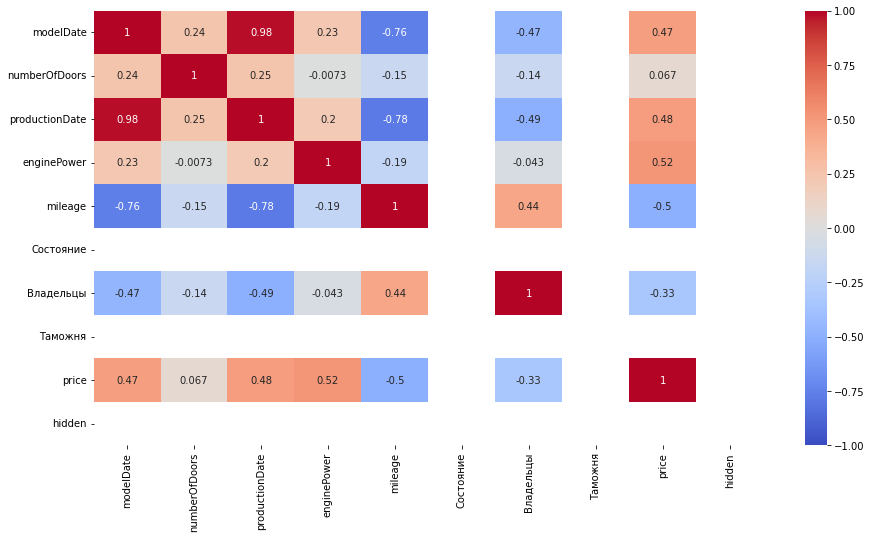

In [17]:
plt.figure(figsize=(15, 8));
sns.heatmap(train.corr(), vmin=-1, vmax=1, annot = True, cmap = 'coolwarm')

Очень высокая корреляция наблюдается между modelDate и productionDate (что вполне логично). Возможно стоит поэксперементировать и удалить один из признаков.

Также наблюдается относительно сильная корреляция между milage и modelDate/productionDate. И это тоже логично - чем старее машина, тем больше пробег.

Есть некая корреляция между количеством владельцев и modelDate/productionDate, что тоже вполне логично - чем больше лет машине, тем больше количество владельцев.


Теперь посмотрим, какие колонки присутствуют и в train, и в test:

In [18]:
set(test.columns).intersection(train.columns)

{'bodyType',
 'brand',
 'color',
 'description',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'modelDate',
 'name',
 'numberOfDoors',
 'productionDate',
 'vehicleConfiguration',
 'vehicleTransmission',
 'Владельцы',
 'Владение',
 'ПТС',
 'Привод',
 'Руль',
 'Состояние',
 'Таможня'}

Добавим в список колонок ниже еще следующие (на мой взгляд, важные) колонки: color, enginePower, fuelType, modelDate, vehicleTransmission, Владельцы, Привод, Руль, Состояние

In [19]:
columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage', 'color', 'enginePower',
           'fuelType', 'modelDate', 'vehicleTransmission', 'Владельцы', 'Привод', 'Руль', 'Состояние']
df_train = train[columns]
df_test = test[columns]

In [20]:
y = train['price']

## Label Encoding

In [21]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,bodyType,brand,productionDate,engineDisplacement,mileage,color,enginePower,fuelType,modelDate,vehicleTransmission,Владельцы,Привод,Руль,Состояние,sample
0,лифтбек,SKODA,2014,1.2 LTR,74000,синий,105 N12,бензин,2013.0,роботизированная,3 или более,передний,Левый,Не требует ремонта,0
1,лифтбек,SKODA,2017,1.6 LTR,60563,чёрный,110 N12,бензин,2017.0,механическая,1 владелец,передний,Левый,Не требует ремонта,0
2,лифтбек,SKODA,2014,1.8 LTR,88000,серый,152 N12,бензин,2013.0,роботизированная,1 владелец,передний,Левый,Не требует ремонта,0
3,лифтбек,SKODA,2014,1.6 LTR,95000,коричневый,110 N12,бензин,2013.0,автоматическая,1 владелец,передний,Левый,Не требует ремонта,0
4,лифтбек,SKODA,2012,1.8 LTR,58536,белый,152 N12,бензин,2008.0,автоматическая,1 владелец,передний,Левый,Не требует ремонта,0


In [22]:
#числовые:
num_cols = []

# бинарные, количество уникальных значений которых равно двум
bin_cols = []

# категориальные
cat_cols = []

### Предобработка bodyType:

In [23]:
data['bodyType'].value_counts()

Внедорожник 5 дв.             19984
Седан                         16662
седан                         13147
внедорожник 5 дв.             12228
Лифтбек                        2566
                              ...  
Универсал 5 дв. California        1
Минивэн Caravan Elgrand           1
Универсал 5 дв. Plus              1
Универсал 5 дв. Shuttle           1
Компактвэн Joy                    1
Name: bodyType, Length: 126, dtype: int64

In [24]:
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())
data['bodyType'].value_counts()

внедорожник      32498
седан            31110
хэтчбек           5432
лифтбек           5099
универсал         2708
минивэн           2283
купе              1787
компактвэн        1124
пикап              673
купе-хардтоп       351
фургон             231
родстер            227
кабриолет          199
седан-хардтоп       29
микровэн            15
лимузин             12
тарга                5
фастбек              3
nan                  1
Name: bodyType, dtype: int64

Распределение признака:

<AxesSubplot:>

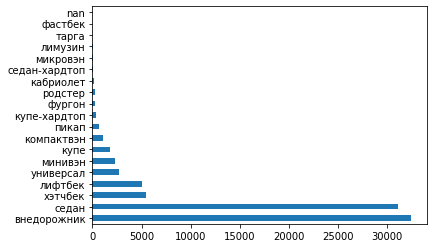

In [25]:
data.bodyType.value_counts().plot.barh()

In [26]:
cat_cols.append('bodyType')

### Предобработка brand

In [27]:
data.brand.value_counts()

MERCEDES      12159
BMW           11838
VOLKSWAGEN    11515
NISSAN        10143
TOYOTA         8708
AUDI           7491
MITSUBISHI     6762
SKODA          5536
VOLVO          3525
HONDA          2323
INFINITI       1907
LEXUS          1880
Name: brand, dtype: int64

Распределение признака:

<AxesSubplot:>

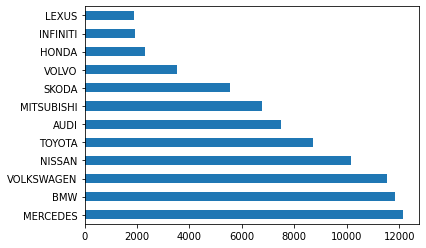

In [28]:
data.brand.value_counts().plot.barh()

In [29]:
cat_cols.append('brand')

### Предобработка productionDate

In [30]:
data.productionDate.value_counts()

2020    10370
2012     5791
2008     5718
2011     5511
2013     5045
        ...  
1949        2
1948        2
1964        2
1954        1
1966        1
Name: productionDate, Length: 72, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


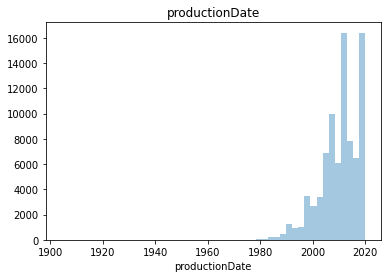

In [31]:
plt.figure()
sns.distplot(data.productionDate.dropna(), kde = False, rug=False)
plt.title('productionDate')
plt.show()

In [32]:
num_cols.append('productionDate')

Создадим еще один признак - количество лет машине (используем 2020, потому что датасет из 2020 года):

In [33]:
data['old_years'] = 2020 - data.productionDate
num_cols.append('old_years')

### Преодбработка engineDisplacement

In [34]:
data.engineDisplacement.value_counts()

2.0 LTR    7391
2.0        7031
1.6        5726
1.6 LTR    4973
3.0 LTR    3915
           ... 
4.0d          1
3.5d          1
Regius        1
Emina         1
116           1
Name: engineDisplacement, Length: 466, dtype: int64

In [35]:
data.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d',
       '2.5d', '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3',
       '1.4', '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '3.0d',
       '2.7d', '16V', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55',
       '2.7', '4.2', 'S-tronic', 'Tiptronic', 'Long',

Думаю, что стоит удалить столбец. Среди значений встречаются и полезные данные (типа литража двигателя), но все-таки не так просто будет выделит полезную информацию.

In [36]:
data = data.drop(['engineDisplacement'], axis=1)

### Предобработка mileage

In [37]:
data.mileage.value_counts()

0         10953
200000     1000
150000      878
300000      834
250000      829
          ...  
55812         1
182480        1
264642        1
113304        1
520           1
Name: mileage, Length: 17170, dtype: int64

Распределение признака:

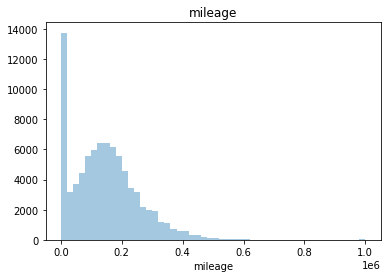

In [38]:
plt.figure()
sns.distplot(data.mileage.dropna(), kde = False, rug=False)
plt.title('mileage')
plt.show()

In [39]:
num_cols.append('mileage')

У нас есть машины, у которых пробег 0?

In [40]:
data[data.mileage == 0].mileage.count()

10953

Добавим новый признак:

In [41]:
data['is_new'] = data.mileage.apply(lambda x: 1 if x == 0 else 0)
bin_cols.append('is_new')

### Предобработка color

In [42]:
data.color.value_counts()

040001         16135
чёрный         11010
FAFBFB          8988
белый           6133
97948F          5622
CACECB          5497
0000CC          4963
серебристый     4113
серый           3984
синий           3289
200204          2028
EE1D19          1784
красный         1531
коричневый      1501
007F00          1321
зелёный          952
C49648           857
бежевый          639
22A0F8           591
голубой          457
DEA522           317
660099           314
золотистый       266
пурпурный        254
4A2197           248
FFD600           224
фиолетовый       219
FF8649           199
жёлтый           194
оранжевый        131
розовый           13
FFC0CB            13
Name: color, dtype: int64

Очистим данные:

In [43]:
color_dict = {'040001':"чёрный", 'EE1D19': 'красный', '0000CC':'синий', 'CACECB':'серебристый',\
              '007F00':'зелёный', 'FAFBFB':'белый', '97948F':'серый', '22A0F8':'голубой',\
              '660099':'пурпурный', '200204':'коричневый', 'C49648':'бежевый',\
              'DEA522':'золотистый','4A2197':'фиолетовый', 'FFD600':'жёлтый',\
              'FF8649':'оранжевый', 'FFC0CB':'розовый'}

data['color'].replace(color_dict, inplace=True)
data.color.value_counts()

чёрный         27145
белый          15121
серебристый     9610
серый           9606
синий           8252
коричневый      3529
красный         3315
зелёный         2273
бежевый         1496
голубой         1048
золотистый       583
пурпурный        568
фиолетовый       467
жёлтый           418
оранжевый        330
розовый           26
Name: color, dtype: int64

<AxesSubplot:>

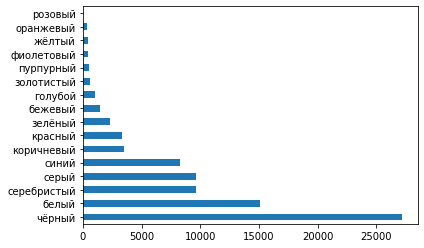

In [44]:
data.color.value_counts().plot.barh()

In [45]:
cat_cols.append('color')

### Предобработка enginePower

In [46]:
data.enginePower.value_counts()

249.0      3377
150.0      3158
110.0      1872
190.0      1802
249 N12    1708
           ... 
514 N12       1
626 N12       1
42 N12        1
38 N12        1
61.0          1
Name: enginePower, Length: 631, dtype: int64

In [47]:
data.enginePower = data.enginePower.astype(str)
data.enginePower = data.enginePower.apply(lambda x: float(x.split(" ")[0]))
data.enginePower = data.enginePower.fillna(data.enginePower.mean())
num_cols.append('enginePower')

### Предобработка fuelType

In [48]:
data.fuelType.value_counts()

бензин       67863
дизель       15264
гибрид         491
электро        151
газ             17
универсал        1
Name: fuelType, dtype: int64

<AxesSubplot:>

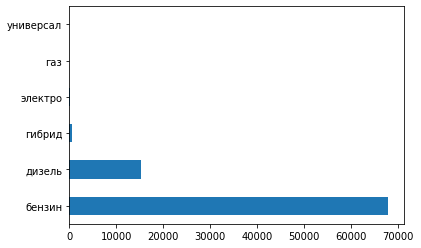

In [49]:
data.fuelType.value_counts().plot.barh()

In [50]:
cat_cols.append('fuelType')

### Предобработка modelDate

In [51]:
data.modelDate.value_counts()

2017.0    5107
2010.0    5063
2006.0    4842
2008.0    4739
2009.0    4597
          ... 
1965.0       2
1973.0       2
1969.0       2
1950.0       1
1957.0       1
Name: modelDate, Length: 69, dtype: int64

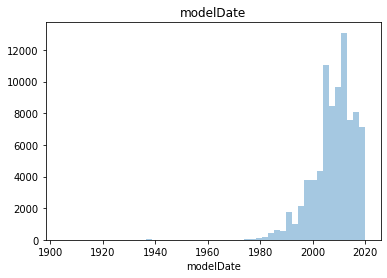

In [52]:
plt.figure()
sns.distplot(data.modelDate.dropna(), kde = False, rug=False)
plt.title('modelDate')
plt.show()

In [53]:
data['modelDate'] = data['modelDate'].fillna(data['modelDate'].mean())
num_cols.append('modelDate')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83787 entries, 0 to 83786
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             83787 non-null  object 
 1   brand                83787 non-null  object 
 2   productionDate       83787 non-null  int64  
 3   mileage              83787 non-null  int64  
 4   color                83787 non-null  object 
 5   enginePower          83787 non-null  float64
 6   fuelType             83787 non-null  object 
 7   modelDate            83787 non-null  float64
 8   vehicleTransmission  83786 non-null  object 
 9   Владельцы            72834 non-null  object 
 10  Привод               83786 non-null  object 
 11  Руль                 83787 non-null  object 
 12  Состояние            34686 non-null  object 
 13  sample               83787 non-null  int64  
 14  old_years            83787 non-null  int64  
 15  is_new               83787 non-null 

Создадим новый признак:

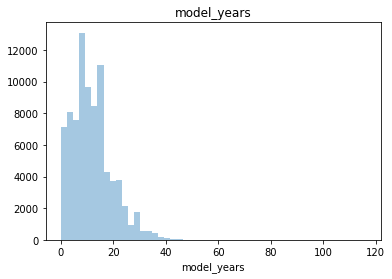

In [54]:
data['model_years'] = 2020 - data.modelDate
data['model_years'] = data['model_years'].fillna(0)
num_cols.append('model_years')

plt.figure()
sns.distplot(data.model_years.dropna(), kde = False, rug=False)
plt.title('model_years')
plt.show()

### Предобработка vehicleTransmission

In [55]:
data.vehicleTransmission.value_counts()

AUTOMATIC           28306
автоматическая      19596
MECHANICAL           8797
механическая         7209
VARIATOR             6245
ROBOT                5752
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [56]:
trans_dict = {'MECHANICAL': 'механическая','AUTOMATIC':'автоматическая', 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'}
data['vehicleTransmission'].replace(trans_dict,inplace=True)
data.vehicleTransmission.value_counts()

автоматическая      47902
механическая        16006
вариатор            10244
роботизированная     9634
Name: vehicleTransmission, dtype: int64

<AxesSubplot:>

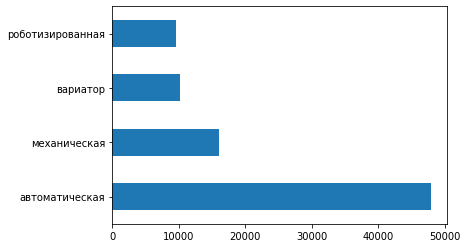

In [57]:
data.vehicleTransmission.value_counts().plot.barh()

In [58]:
cat_cols.append('vehicleTransmission')

### Предобработка Владельцы

In [59]:
data['Владельцы'].value_counts()

3.0            19031
3 или более    15957
2.0            10211
1 владелец      9459
2 владельца     9270
1.0             8906
Name: Владельцы, dtype: int64

In [60]:
owners_dict = {3.0: '3 или более', 2.0: '2\xa0владельца', 1.0: '1\xa0владелец'}
data['Владельцы'].replace(owners_dict, inplace=True)
data['Владельцы'].value_counts()

3 или более    34988
2 владельца    19481
1 владелец     18365
Name: Владельцы, dtype: int64

<AxesSubplot:>

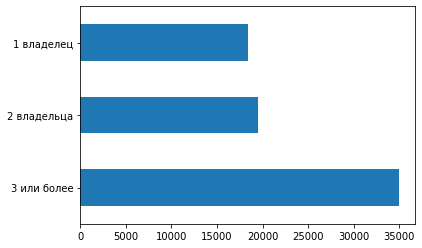

In [61]:
data['Владельцы'].value_counts().plot.barh()

In [62]:
data = data.rename(columns = {'Владельцы':'owner_count'})
cat_cols.append('owner_count')

### Предобработка Привод

In [63]:
data['Привод'].value_counts()

полный      38592
передний    35173
задний      10021
Name: Привод, dtype: int64

<AxesSubplot:>

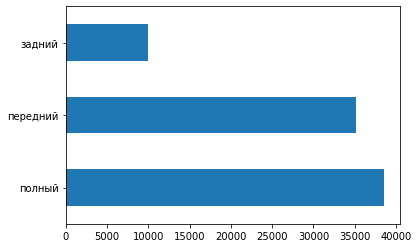

In [64]:
data['Привод'].value_counts().plot.barh()

In [65]:
data = data.rename(columns = {'Привод':'wd_type'})
cat_cols.append('wd_type')

### Предобработка Руль

In [66]:
data['Руль'].value_counts()

LEFT      47568
Левый     33287
RIGHT      1533
Правый     1399
Name: Руль, dtype: int64

In [67]:
wheel_dict = { 'Левый': 'LEFT', 'Правый': 'RIGHT'}
data['Руль'].replace(wheel_dict, inplace=True)
data['Руль'].value_counts()

LEFT     80855
RIGHT     2932
Name: Руль, dtype: int64

In [68]:
data = data.rename(columns = {'Руль':'wheel_type'})
cat_cols.append('wheel_type')

### Предобработка Состояние

In [69]:
data['Состояние'].value_counts()

Не требует ремонта    34686
Name: Состояние, dtype: int64

In [70]:
data['Состояние'] = data['Состояние'].apply(lambda x: 1 if x == 'Не требует ремонта' else 0).astype('int8')
data = data.rename(columns = {'Состояние':'condition'})
bin_cols.append('condition')

data.condition.value_counts()

0    49101
1    34686
Name: condition, dtype: int64

In [71]:
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes

In [72]:
data

,bodyType,brand,productionDate,mileage,color,enginePower,fuelType,modelDate,vehicleTransmission,owner_count,wd_type,wheel_type,condition,sample,old_years,is_new,model_years
0,7,8,2014,74000,13,105.0,0,2013.0,3,2,1,0,1,0,6,0,7.0
1,7,8,2017,60563,15,110.0,0,2017.0,2,0,1,0,1,0,3,0,3.0
2,7,8,2014,88000,12,152.0,0,2013.0,3,0,1,0,1,0,6,0,7.0
3,7,8,2014,95000,6,110.0,0,2013.0,0,0,1,0,1,0,6,0,7.0
4,7,8,2012,58536,1,152.0,0,2008.0,0,0,1,0,1,0,8,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83782,4,5,1952,45200,5,150.0,0,1951.0,2,0,0,0,0,1,68,0,69.0
83783,12,5,1959,10000,15,160.0,0,1957.0,0,1,0,0,0,1,61,0,63.0
83784,10,5,2018,800,12,258.0,3,2017.0,0,0,2,0,0,1,2,0,3.0
83785,10,5,2018,15850,12,190.0,3,2017.0,0,0,2,0,0,1,2,0,3.0


In [73]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# # Model 1 : RandomForestRegressor

In [75]:
model = RandomForestRegressor(random_state=RANDOM_SEED)
model.fit(X_train, np.log(y_train))

predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.07%


LeaderBoard score 12.29014

# # Model 2 : ExtraTreesRegression

In [76]:
model = ExtraTreesRegressor(random_state=RANDOM_SEED)
model.fit(X_train, np.log(y_train))
     
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.35%


**LeaderBoard score 11.24685 - this is the best model among all!**

# # Model 3 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [77]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [78]:
# оцениваем точность
predict_test = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.51%


### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [79]:
np.log(y_train)

75311    14.552531
25063    13.161584
84326    14.922620
71936    13.764217
70345    13.217674
           ...    
11325    15.702429
84276    13.815511
75629    14.880221
865      12.641097
43187    12.230765
Name: price, Length: 39280, dtype: float64

In [80]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [81]:
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

In [82]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.67%


Leader Board score: 13.38145

# # Model 4 : KNeighborsRegressor

In [83]:
model = KNeighborsRegressor(n_neighbors=2, weights = 'distance', p=1)
model.fit(X_train, np.log(y_train))
     
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 32.41%


# # Model 5 : GradientBoostingRegressor с подбором оптимизированных параметров

In [84]:
# Подбор параметров делал на локальном компьютере:

#param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
#              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}

#model = GradientBoostingRegressor(random_state=42, learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None)
#gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
#gs.fit(X_train, np.log(y_train))
     
#predict_test = np.exp(gs.best_estimator_.predict(X_test))
#predict_submission = np.exp(gs.best_estimator_.predict(X_sub))

#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

#gs.best_estimator_.get_params()

Получились такие оптимальные параметры:

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1750,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [85]:
model = GradientBoostingRegressor(random_state=42, learning_rate=0.1, n_estimators=1750,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None)
model.fit(X_train, np.log(y_train))
     
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.69%


LeaderBoard score 14.77627.

# # Model 6 : ExtraTreesRegressor с подбором параметров

In [86]:
param_grid = {'max_depth': [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 
              'max_features': ['sqrt', 'log2'],
              'oob_score': [True, False]}

model = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, warm_start=True, n_estimators=500, bootstrap=True)
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
gs.fit(X_train, np.log(y_train))
     
predict_test = np.exp(gs.best_estimator_.predict(X_test))
#predict_submission = np.exp(gs.best_estimator_.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

gs.best_estimator_.get_params()

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names


Точность модели по метрике MAPE: 13.22%


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 25,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': True}

LeaderBoard score 12.57278

# # Model 7 : StackingRegressor

In [87]:
estimators = [
    ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
    ('gbr', GradientBoostingRegressor(random_state=42, learning_rate=0.1, n_estimators=1750,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None)),
    ('rfr', RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200))
]

model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

model.fit(X_train, np.log(y_train))

predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))
     
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    4.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Точность модели по метрике MAPE: 12.61%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


LeaderBoard score 12.21737

# Submission

In [88]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.490000e+05
1,1100549428,8.950000e+05
2,1100658222,8.482943e+05
3,1100937408,6.912100e+05
4,1101037972,6.535416e+05
5,1100912634,7.174750e+05
6,1101228730,5.719380e+05
7,1100165896,3.650000e+05
8,1100768262,1.757288e+06
9,1101218501,7.851081e+05
